In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Convert data to float32 and normalize
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

In [ ]:
train_indeces = np.where((y_train == 0) | (y_train == 1) | (y_train == 2))
test_indeces = np.where((y_test == 0) | (y_test == 1) | (y_test == 2))

x_train, y_train = x_train[train_indeces], y_train[train_indeces]
x_test, y_test = x_test[test_indeces], y_test[test_indeces]

In [ ]:
# Compute Hu moments for each image
def calculate_hu_moments(images):
    hu_moments = []
    for img in images:
        moments = cv2.moments(img)
        hu = cv2.HuMoments(moments).flatten()
        hu_moments.append(hu)
    return np.array(hu_moments)

hu_train = calculate_hu_moments(x_train)
hu_test = calculate_hu_moments(x_test)

In [ ]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
hu_train = scaler.fit_transform(hu_train)
hu_test = scaler.transform(hu_test)

In [ ]:
# Categorize the labels
y_train_categorical = to_categorical(y_train, 3)
y_test_categorical = to_categorical(y_test, 3)

In [ ]:
# Define the MLP model
model = Sequential([
    Input(shape=hu_train.shape[1]),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 128)               1024      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 3)                 195       
                                                                 
Total params: 9475 (37.01 KB)
Trainable params: 9475 (37.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(hu_train, y_train_categorical, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
524/524 [==============================] - 4s 5ms/step - loss: 0.3636 - accuracy: 0.8748 - val_loss: 0.2161 - val_accuracy: 0.9286
Epoch 2/20
524/524 [==============================] - 2s 4ms/step - loss: 0.2331 - accuracy: 0.9181 - val_loss: 0.2029 - val_accuracy: 0.9286
Epoch 3/20
524/524 [==============================] - 2s 4ms/step - loss: 0.2168 - accuracy: 0.9237 - val_loss: 0.2000 - val_accuracy: 0.9291
Epoch 4/20
524/524 [==============================] - 2s 4ms/step - loss: 0.2083 - accuracy: 0.9266 - val_loss: 0.1965 - val_accuracy: 0.9318
Epoch 5/20
524/524 [==============================] - 2s 4ms/step - loss: 0.2025 - accuracy: 0.9261 - val_loss: 0.1901 - val_accuracy: 0.9308
Epoch 6/20
524/524 [==============================] - 2s 4ms/step - loss: 0.2006 - accuracy: 0.9271 - val_loss: 0.1928 - val_accuracy: 0.9265
Epoch 7/20
524/524 [==============================] - 3s 5ms/step - loss: 0.1972 - accuracy: 0.9271 - val_loss: 0.1873 - val_accuracy: 0.9286
Epoch 

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(hu_test, y_test_categorical)
print(f'Accuracy on test data: {test_accuracy * 100:.2f}%')

99/99 [==============================] - 0s 4ms/step - loss: 0.1719 - accuracy: 0.9352
Accuracy on test data: 93.52%


99/99 [==============================] - 0s 1ms/step


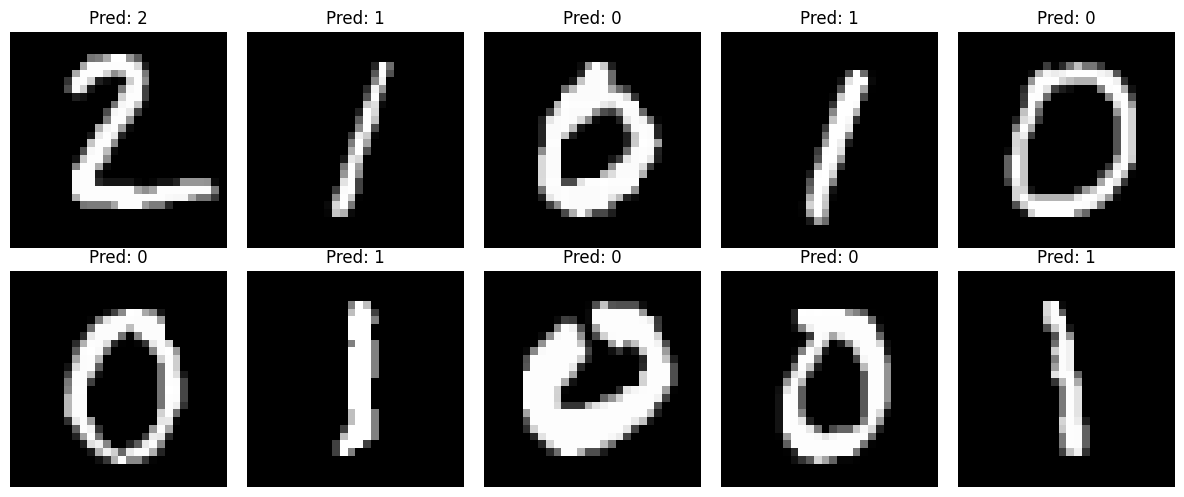

In [ ]:
# Predict the labels of the test set
predicted_labels = model.predict(hu_test)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Display some images with their predicted labels
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(x_test[i], cmap='gray')
    axes[i].set_title(f'Pred: {predicted_labels[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

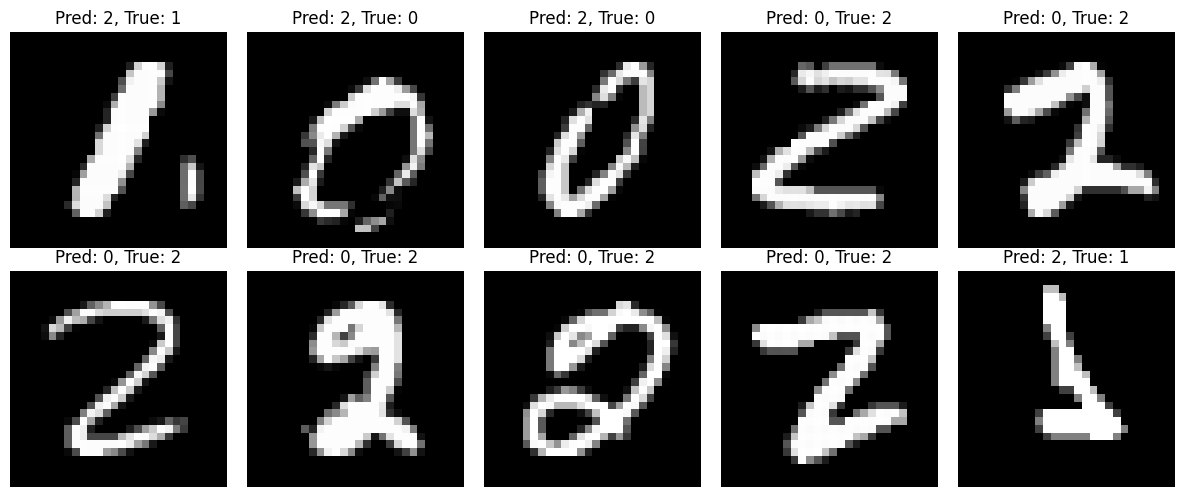

In [ ]:
wrong_labels = np.where(y_test != predicted_labels)[0]
ten_wrong_labels = np.random.choice(wrong_labels, size=10, replace=False)

# Display some images with their predicted labels
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(len(ten_wrong_labels)):
    axes[i].imshow(x_test[ten_wrong_labels[i]], cmap='gray')
    axes[i].set_title(f'Pred: {predicted_labels[ten_wrong_labels[i]]}, True: {y_test[ten_wrong_labels[i]]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()